# Preprocessing

In [7]:
import scipy.io as scio
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.measure import label

## Get data - without baseline 
Removal method from Gniadecka

In [2]:
tissue3 = scio.loadmat('../Data/tissue3_1.mat')
tissue6 = scio.loadmat('../Data/tissue6.mat')
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

tissue_data = [tissue3,tissue6,tissue30,tissue31,tissue34_1,tissue34_2,tissue36,tissue37,tissue39_1]
file_names = ['map_t3_nobl.txt','map_t6_nobl.txt','map_t30_nobl.txt','map_t31_nobl.txt','map_t34_1_nobl.txt','map_t34_2_nobl.txt','map_t36_nobl.txt','map_t37_nobl.txt','map_t39_1_nobl.txt']

In [3]:
tissues = []
count = 0
for item in tissue_data: 
    t_IDX = item['IDX']
    t_bcc = item['bcc']
    width = t_bcc.shape[0]
    height = t_bcc.shape[1]
    t_map = np.loadtxt(file_names[count]).reshape(width*height,1024)
    tissues.append((t_map,t_bcc,t_IDX,width,height))
    count += 1
    
# tissues: (t_map, t_bcc, t_IDX, width, height)

In [4]:
## Train PCA only on relevant BCC data
pca_training_data = np.zeros((1000,1024))
count = 0

for tissue in tissues:
    for i in range(width):
        for j in range(height):
            if count < 1000:
                if tissue[1][i,j] == 1:
                    index = i*height + j
                    pca_training_data[count] = tissue[0][index,:]
                    count += 1

## PCA dimensionality reduction

In [5]:
# Fit PCA to data and transform all spectra    
norm_data = normalize(pca_training_data)
pca = PCA(n_components=200)
pca.fit(norm_data)

for i in range(len(tissues)): 
    transformed = pca.transform(tissues[i][0])
    tissues[i] = (transformed,tissues[i][1],tissues[i][2],tissues[i][3],tissues[i][4])
    

In [6]:
## Reshape to regain spatial information
new_tissues = []

for i in range(len(tissues)):
    (t_map,t_bcc,t_IDX,width,height) = tissues[i]
    new_map = np.zeros((width,height,200))
    
    for i in range(width):
        for j in range(height):
            index = i*height + j
            new_map[i,j,:] = t_map[index,:]
    
    new_tissues.append((new_map,t_bcc,t_IDX,width,height))

# Compare to an average bcc spectra


In [67]:
selected = [tissues[0], tissues[2], tissues[3], tissues[7], tissues[8]]

In [132]:
## Find average spectrum of BCC
spectra = np.zeros((100000,200))
count = 0

for (t_map,t_bcc,_,width,height) in selected:
    for i in range(width):
        for j in range(height):
            if t_bcc[i,j] == 1:
                index = i*height + j
                spectra[count,:] = t_map[index,:]
                count += 1
avg_spectrum = np.mean(spectra[:count,:],0)
std_spectrum = np.mean(np.std(spectra[:count,:],0))
print(count)


20929


In [133]:
# Repeat but only if less than X std away from avg
for i in range(1):
    spectra = np.zeros((100000,200))
    count = 0

    for (t_map,t_bcc,_,width,height) in selected:
        for i in range(width):
            for j in range(height):                
                if t_bcc[i,j] == 1:
                    index = i*height + j
                    distance = sum(np.squeeze(abs(avg_spectrum - t_map[index,:])))
                    if distance < 8 * std_spectrum:
                        spectra[count,:] = t_map[index,:]
                        count += 1
    
    avg_spectrum = np.mean(spectra[:count,:],0)
    std_spectrum = np.mean(np.std(spectra[:count,:],0))
    print(count)

16211


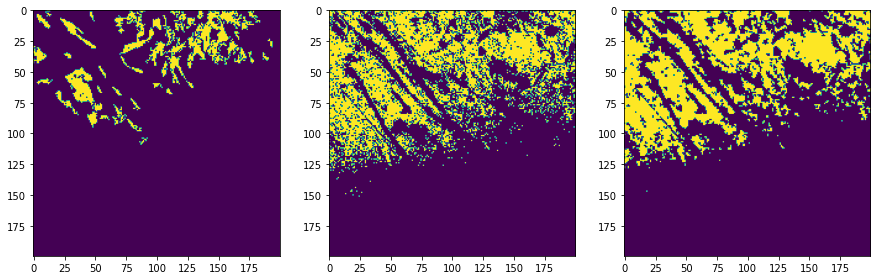

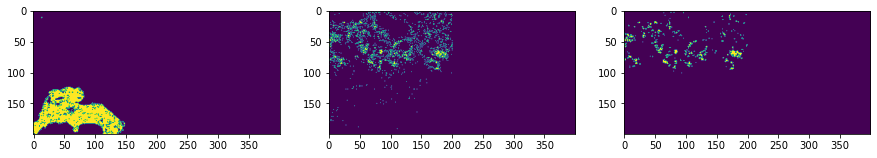

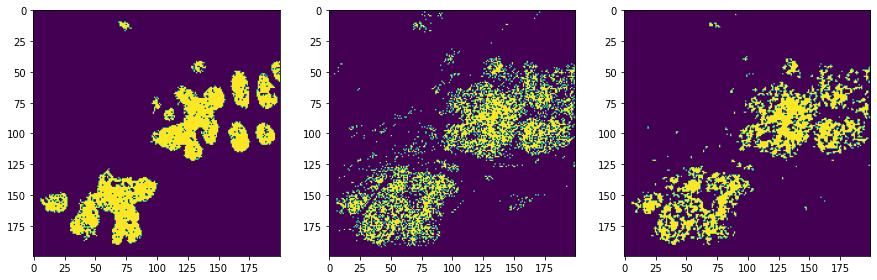

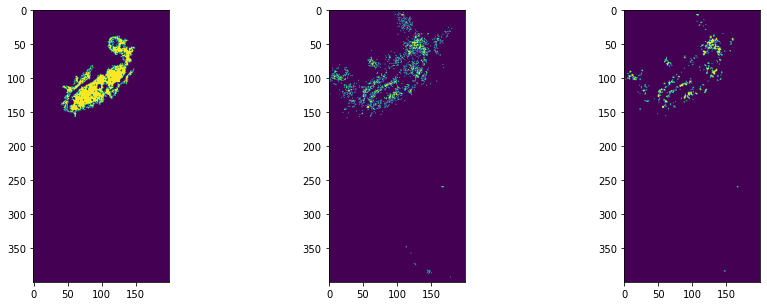

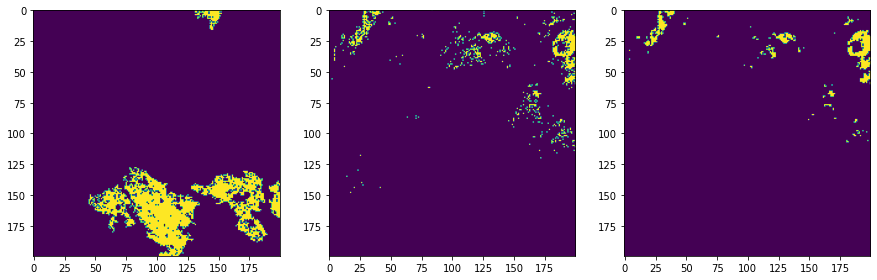

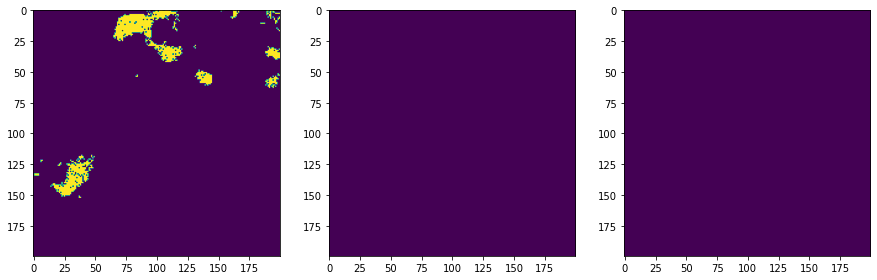

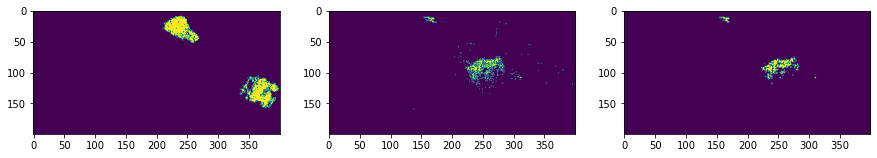

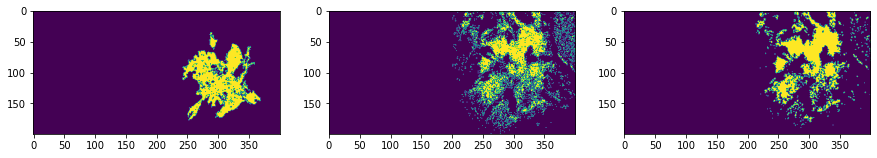

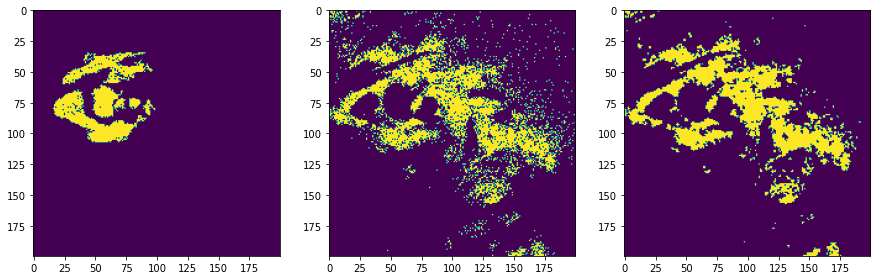

In [158]:
from scipy.ndimage import gaussian_filter

# Plot distance from avg spectrum
for (t_map,t_bcc,_,width,height) in tissues:
    distance_matrix = np.zeros((width,height))
    
    for i in range(width):
        for j in range(height):                
            index = i*height + j
            distance = sum(np.squeeze(abs(avg_spectrum - t_map[index,:])))
            distance_matrix[i,j] = distance
            
    mask = distance_matrix < 1450
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(t_bcc)
    axs[1].imshow(np.where(mask==True, 1, 0))
    axs[2].imshow(gaussian_filter(100*mask,sigma=0.7) > 50 )